In [5]:
# Bagian 1: Setup dan Impor Pustaka
!pip install catboost
!pip install scikit-learn pandas joblib

import os
import joblib
import pickle
import pandas as pd
import numpy as np

# Pustaka Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Pustaka ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Diperlukan untuk download file di Google Colab
from google.colab import files

print("Setup Pustaka Selesai. (Pustaka visualisasi ditambahkan)")

Setup Pustaka Selesai. (Pustaka visualisasi ditambahkan)


Dataframe dimuat dengan 97297 baris.


/tmp/ipython-input-2317576973.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, order=y.value_counts().index, palette="viridis")


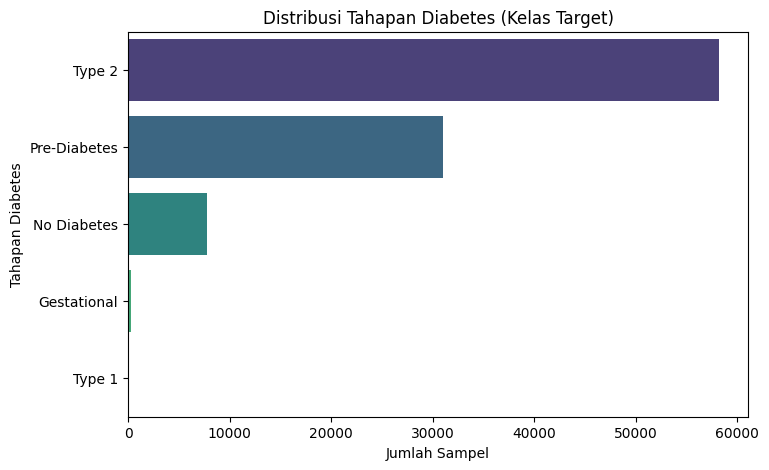


Data Split Selesai. Train=77837, Test=19460


In [6]:
# Bagian 2: Pemuatan Data, Pemisahan X & y, dan Analisis Distribusi Target

file_path = "Diabetes_and_LifeStyle_Dataset .csv"
try:
    df = pd.read_csv(file_path)
    print(f"Dataframe dimuat dengan {len(df)} baris.")
except FileNotFoundError:
    print(f"ERROR: File {file_path} tidak ditemukan. Pastikan Anda sudah mengunggahnya.")
    exit()

# ----------------------------------------------------
# 1. DEFINISI FITUR DAN TARGET
# ----------------------------------------------------
TARGET_COLUMN = "diabetes_stage"
COLUMNS_TO_DROP = ['diagnosed_diabetes', 'diabetes_risk_score']

X = df.drop(COLUMNS_TO_DROP + [TARGET_COLUMN], axis=1)
y = df[TARGET_COLUMN]

# Identifikasi Fitur (Diperlukan untuk Pipeline)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# ----------------------------------------------------
# 2. VISUALISASI DISTRIBUSI TARGET
# ----------------------------------------------------
# Grafik ini menunjukkan apakah data target seimbang (imbalanced)
plt.figure(figsize=(8, 5))
sns.countplot(y=y, order=y.value_counts().index, palette="viridis")
plt.title('Distribusi Tahapan Diabetes (Kelas Target)')
plt.xlabel('Jumlah Sampel')
plt.ylabel('Tahapan Diabetes')
plt.show()

# ----------------------------------------------------
# 3. LABEL ENCODING TARGET DAN SPLIT DATA
# ----------------------------------------------------
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)
global encoders; encoders = {'diabetes_stage': target_encoder} # Simpan encoder

# Split data (80% Train, 20% Test) dengan Stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"\nData Split Selesai. Train={len(X_train)}, Test={len(X_test)}")

In [7]:
# Bagian 3: Pembangunan Pipeline dan Training Model

# ----------------------------------------------------
# 1. PEMBUATAN PREPROCESSING PIPELINE (ColumnTransformer)
# ----------------------------------------------------
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessing Pipeline Selesai Dibuat.")

# ----------------------------------------------------
# 2. PEMBANGUNAN MODEL PIPELINE DAN TRAINING
# ----------------------------------------------------
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        verbose=0,
        random_state=42,
        # Penanganan Imbalance
        auto_class_weights='Balanced'
    ))
])

print("\nMemulai Training CatBoost pada Model Pipeline...")
model_pipeline.fit(X_train, y_train)
print("Training Model Selesai.")

Preprocessing Pipeline Selesai Dibuat.

Memulai Training CatBoost pada Model Pipeline...
Training Model Selesai.


--------------------------------------------------
Akurasi Model pada Data Uji: 0.9134

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.85      1.00      0.92      1548
           2       0.82      1.00      0.90      6203
           3       0.00      0.00      0.00        23
           4       1.00      0.86      0.92     11633

    accuracy                           0.91     19460
   macro avg       0.53      0.57      0.55     19460
weighted avg       0.93      0.91      0.91     19460

--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x600 with 0 Axes>

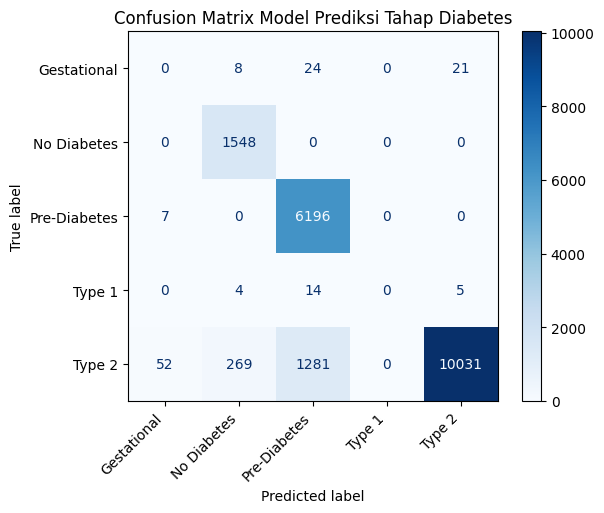


Pipeline Model disimpan: full_diabetes_pipeline.pkl
Target Encoders disimpan: target_encoders.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Semua file deployment telah disimpan dan siap diunduh.


In [8]:
# Bagian 4: Evaluasi, Visualisasi Confusion Matrix, dan Penyimpanan

# ----------------------------------------------------
# 1. PREDIKSI DAN EVALUASI TEKSTUAL
# ----------------------------------------------------
y_pred = model_pipeline.predict(X_test).flatten() # Prediksi

print("-" * 50)
print(f"Akurasi Model pada Data Uji: {accuracy_score(y_test, y_pred):.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))
print("-" * 50)

# ----------------------------------------------------
# 2. VISUALISASI CONFUSION MATRIX
# ----------------------------------------------------
# Confusion Matrix adalah alat visual yang menunjukkan jumlah prediksi benar dan salah per kelas.
class_labels = target_encoder.classes_
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix Model Prediksi Tahap Diabetes')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# ----------------------------------------------------
# 3. PENYIMPANAN ARTEFAK DEPLOYMENT
# ----------------------------------------------------
model_filename = "full_diabetes_pipeline.pkl"
joblib.dump(model_pipeline, model_filename)
print(f"\nPipeline Model disimpan: {model_filename}")

encoders_filename = "target_encoders.pkl"
with open(encoders_filename, "wb") as f:
    pickle.dump(encoders, f)
print(f"Target Encoders disimpan: {encoders_filename}")

# --- Download File ---
try:
    files.download(model_filename)
    files.download(encoders_filename)
    print("\nSemua file deployment telah disimpan dan siap diunduh.")
except Exception:
    print("\nFile telah disimpan ke disk. Silakan unduh secara manual.")